# Test and visualize the driving scenarios

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations
using AutomotiveDrivingModels, AutoUrban, AutoViz
using Reel 

In [2]:
rng = MersenneTwister(1);

 in module Base at util.jl:532 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

In [3]:
include("constants.jl")
include("utils/helpers.jl")
include("utils/occlusions.jl")
include("utils/rendering.jl")

...) in module Base

In [4]:
include("envs/occluded_crosswalk_env.jl")
include("envs/multi_lane_T_env.jl")
include("envs/rendering.jl")

 at util.jl:585 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.


LoadError: LoadError: [91mUndefVarError: UrbanEnv not defined[39m
while loading C:\Users\Maxime\OneDrive - Leland Stanford Junior University\Research\admscenarios\envs\rendering.jl, in expression starting on line 30

In [5]:
include("driver_models/route_following_idm.jl")
include("driver_models/stop.jl")
include("driver_models/intersection_driver.jl")
include("driver_models/constant_pedestrian.jl")
include("driver_models/crosswalk_driver.jl")

dist_to_stop (generic function with 1 method)

## Scenario 1: Single agent occluded crosswalk

Discrete environment, provides explicit transition and observation probability distributions. Support only one pedestrian

In [6]:
# include("single_crosswalk/occluded_crosswalk_env.jl")
include("single_crosswalk/pomdp_types.jl")
include("single_crosswalk/spaces.jl")
include("single_crosswalk/transition.jl")
include("single_crosswalk/observation.jl")
include("single_crosswalk/belief.jl")
include("single_crosswalk/adm_helpers.jl")
include("single_crosswalk/render_helpers.jl")

animate_hist (generic function with 1 method)

In [7]:
pomdp = SingleOCPOMDP()

SingleOCPOMDP(CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(21.500, -4.500)
	VecE2(21.500, -1.500)
], CrosswalkParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 100, 0.5, 2.0, 10.0)), VehicleDef(CAR, 4.000, 1.800), VehicleDef(PEDESTRIAN, 1.000, 1.000), 2.0, 1.0, 1.0, 5.0, -5.0, 37.0, 5.0, 0.5, 0.3, 0.3, false, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 0.95)

In [8]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

**Simulate**

In [9]:
hr = HistoryRecorder(rng=rng)
@time hist = simulate(hr, pomdp, policy, up);

  1.955631 seconds (1.31 M allocations: 68.119 MiB, 0.95% gc time)


**Rendering**

In [10]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpWvnYjZ", 0x000000000000000a, 2.0, nothing)

## Scenario 2: Multi-agent Crosswalk 

Generative model for the occluded crosswalk scenario, support multiple pedestrians, continuous space

In [11]:
# include("multi_crosswalk/occluded_crosswalk_env.jl")
include("multi_crosswalk/pomdp_types.jl")
include("multi_crosswalk/generative_model.jl")
include("multi_crosswalk/render_helpers.jl")

In [12]:
pomdp = OCPOMDP(ΔT=0.5, p_birth=0.2, max_ped=1);
overlay = LidarOverlay(pomdp.sensor);

In [13]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [14]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

  0.557118 seconds (209.97 k allocations: 11.424 MiB, 1.15% gc time)


In [15]:
duration, fps, render_hist = animate_hist(pomdp, hist, SceneOverlay[overlay])
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpVAmi9Y", 0x000000000000000d, 2.0, nothing)

In [16]:
scene = Scene()
models = Dict{Int, DriverModel}()
for i=1:5
    ped = initial_pedestrian(pomdp, scene, rng, true)
    push!(scene, ped)
    models[ped.id] = ConstantPedestrian()
end
car = initial_ego(pomdp, rng)
push!(scene, car)

timestep = 0.1


models[1] = CrosswalkDriver(crosswalk = pomdp.env.crosswalk,
                            intersect = get_lane(pomdp.env.roadway, car))


nticks = 200
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, pomdp.env.roadway, models, nticks)

buffer ped ttc 4.5
ego ttc 3.317094054605299
has_crossed ttc-1.5
min ped ttc -1.2913631479558374
braking! d = 15.0
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.437645981623635
has_crossed ttc-1.5
min ped ttc -0.5577474650613397
braking! d = 14.27015863913942
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.5398191194486066
has_crossed ttc-1.5
min ped ttc -0.6577474650613393
braking! d = 13.584028374252899
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.6287652386861002
has_crossed ttc-1.5
min ped ttc 1.2213613004687165
braking! d = 12.93488855757143
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.708128068968622
has_crossed ttc-1.5
min ped ttc -0.7577474650613389
braking! d = 12.317940794755248
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.7806517633469965
has_crossed ttc-1.5
min ped ttc -0.9580781634652649
braking! d = 11.729628682142737
veh 1 go false stop false clear false
buffer ped t

SceneRecord(nscenes=201)

In [17]:
cam = FitToContentCamera(0.)
duration, fps, render_rec = animate_record(pomdp.env, rec, sim_dt=timestep)
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmp7KJnFp", 0x00000000000000c9, 10.0, nothing)

## Scenario 3 : Single agent intersection

Explicit formulation with transition and observation probability distribution. Only support one vehicle

In [18]:
include("single_intersection/occluded_intersection_env.jl")
include("single_intersection/pomdp_types.jl")
include("single_intersection/spaces.jl")
include("single_intersection/transition.jl")
include("single_intersection/observation.jl")
include("single_intersection/belief.jl")
include("single_intersection/render_helpers.jl")

animate_hist (generic function with 4 methods)

In [19]:
pomdp = SingleOIPOMDP();

In [20]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [21]:
hr = HistoryRecorder(rng=rng, max_steps=100)
hist = simulate(hr, pomdp, policy, up);

In [22]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmptNRIux", 0x000000000000000b, 2.0, nothing)

## Scenario 4 - Multi Lane Multi agent intersection

In [23]:
# include("multi_lane_T_intersection/multi_lane_T_env.jl")
include("multi_lane_T_intersection/pomdp_types.jl")
include("multi_lane_T_intersection/generative_model.jl")
include("multi_lane_T_intersection/render_helpers.jl")

In [24]:
include("driver_models/intersection_driver.jl")

20-Feb 14:22:03:WARNING:root:replacing docs for 'grow_wait_list! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
20-Feb 14:22:03:WARNING:root:replacing docs for 'ungrow_wait_list! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
20-Feb 14:22:03:WARNING:root:replacing docs for 'tts :: Tuple{Float64,Float64}' in module 'Main'.
20-Feb 14:22:03:WARNING:root:replacing docs for 'is_at_intersection :: Tuple{StopIntersectionDriver,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},AutomotiveDrivingModels.Roadway}' in module 'Main'.
20-Feb 14:22:03:WARNING:root:replacing docs for 'update_priority! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity

get_dist_to_end

In [25]:
env = IntersectionEnv(TInterParams(nlanes_main = 1))
pomdp = OIPOMDP(env=env, ΔT=0.5, max_cars=10);

In [26]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

mutable struct AccelPolicy <: Policy
    problem::OIPOMDP
end
policy = AccelPolicy(pomdp)
function POMDPs.action(policy::AccelPolicy, b::Void)
    return actions(policy.problem)[2]
end

In [27]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

  0.661128 seconds (231.43 k allocations: 14.006 MiB)


In [28]:
duration, fps, render_hist = animate_hist(pomdp, hist, [IDOverlay()])
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpaVDv0n", 0x0000000000000064, 2.0, nothing)

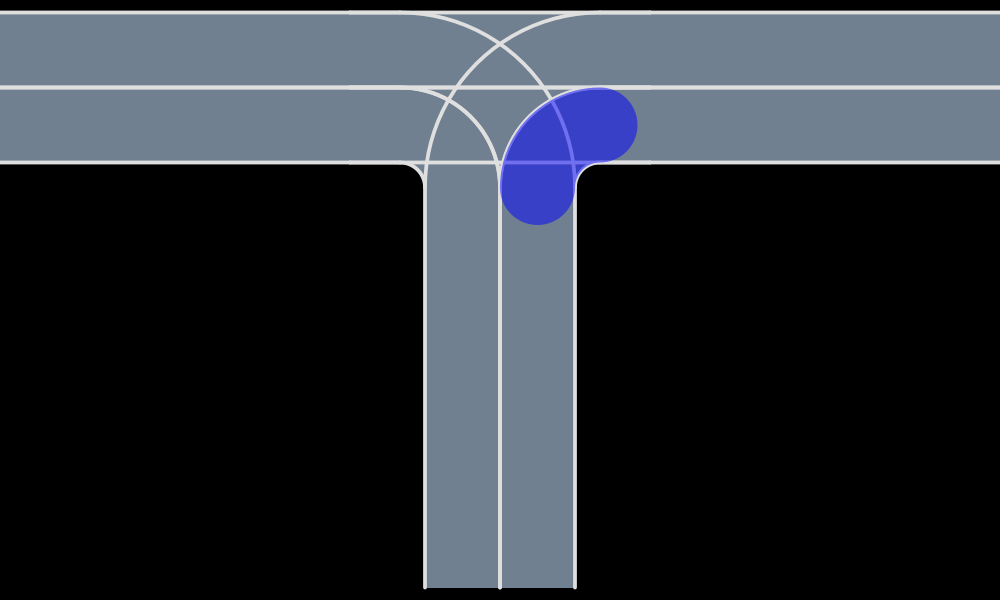

In [29]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(env.roadway.segments)
#     AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))
# end

i=15
AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))

In [30]:
include("driver_models/intersection_driver.jl")

20-Feb 14:22:22:WARNING:root:replacing docs for 'grow_wait_list! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
20-Feb 14:22:22:WARNING:root:replacing docs for 'ungrow_wait_list! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
20-Feb 14:22:22:WARNING:root:replacing docs for 'tts :: Tuple{Float64,Float64}' in module 'Main'.
20-Feb 14:22:22:WARNING:root:replacing docs for 'is_at_intersection :: Tuple{StopIntersectionDriver,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},AutomotiveDrivingModels.Roadway}' in module 'Main'.
20-Feb 14:22:22:WARNING:root:replacing docs for 'update_priority! :: Tuple{StopIntersectionDriver,Records.Frame{Records.Entity

get_dist_to_end

In [31]:
scene = Scene()
for i = 1:20
    veh = initial_car(pomdp, scene, rng, true)
    push!(scene, veh)
end
clean_scene!(pomdp.env, scene)

timestep = 0.1

models = Dict{Int, DriverModel}()
# constant speed model
for veh in scene
    route = random_route(rng, env.roadway, lane)
    intersection_entrances = get_start_lanes(env.roadway)
    intersection_exits = get_exit_lanes(intersection_entrances, env.roadway)
    models[veh.id] = StopIntersectionDriver(navigator=RouteFollowingIDM(route=route),
                                   intersection=Lane[route[1], route[2]], 
                                   intersection_entrances = intersection_entrances,
                                   intersection_exits = intersection_exits,
                                   stop_delta=0.,
                                   accel_tol=0.)
end
# models[0] = RouteFollowingIDM(route=route)

nticks = 100
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, env.roadway, models, nticks)

LoadError: [91mUndefVarError: lane not defined[39m

In [32]:
duration, fps, render_rec = animate_record(rec, env, sim_dt=timestep)
film = roll(render_rec, fps = fps, duration = duration)

LoadError: [91mMethodError: no method matching render(::Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}}, ::Array{AutoViz.SceneOverlay,1}, ::IntersectionEnv; cam=AutoViz.FitToContentCamera(0.0), car_colors=Dict{Int64,ColorTypes.Colorant}(Pair{Int64,ColorTypes.Colorant}(7, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(4, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(2, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(3, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(16, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(19, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(11, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(12, RGB{N0f8}(1.0,0.0,0.498))))[0m
Closest candidates are:
  render(::Records.Frame{Records.Entity{S,D,I}}, ::R; canvas_width, canvas_height, rendermodel, cam, car_colors) where {S, D, I, R} at /home/boutonm/.julia/v0.6/AutoViz/src/interface.jl:60
  render(::Records.Frame{Records.Entity{S,D,I}}, ::R, [91m::AbstractArray{O<:AutoViz.SceneOverlay,1}[39m; canvas_width, canvas_height, rendermodel, cam, car_colors) where {S, D, I, O<:AutoViz.SceneOverlay, R} at /home/boutonm/.julia/v0.6/AutoViz/src/overlays.jl:25
  render([91m::Cairo.CairoContext[39m, [91m::Records.Frame{Records.Entity{S,D,I}}[39m, ::R; rendermodel, cam, car_colors) where {S, D, I, R} at /home/boutonm/.julia/v0.6/AutoViz/src/interface.jl:39
  ...[39m